20240713_192951.jpg -> Screws: 14, Bolts: 20


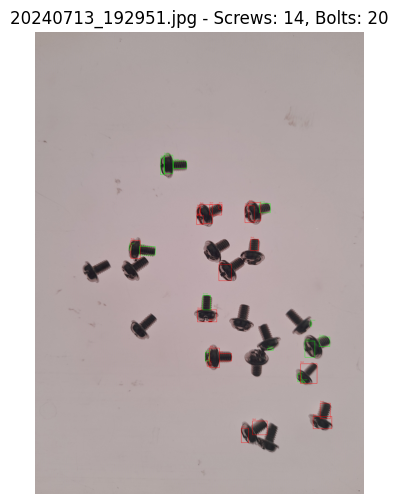

20240713_194200.jpg -> Screws: 41, Bolts: 47


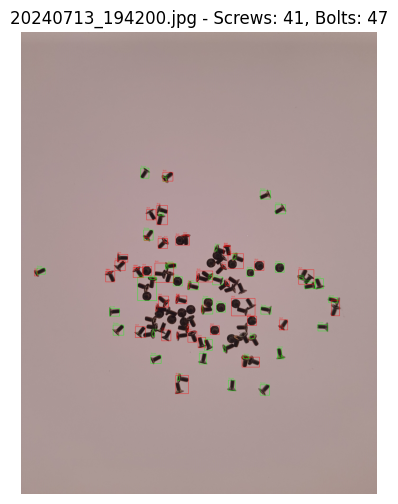

20240713_194316.jpg -> Screws: 75, Bolts: 50


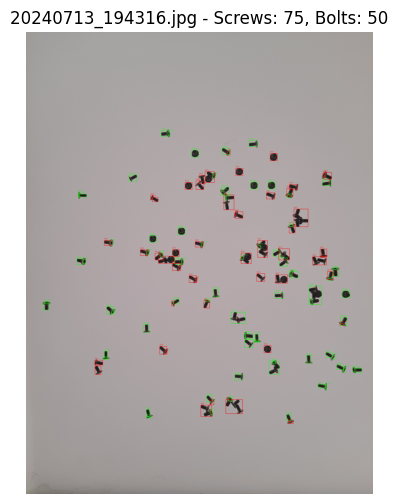

20240713_193659.jpg -> Screws: 1, Bolts: 2


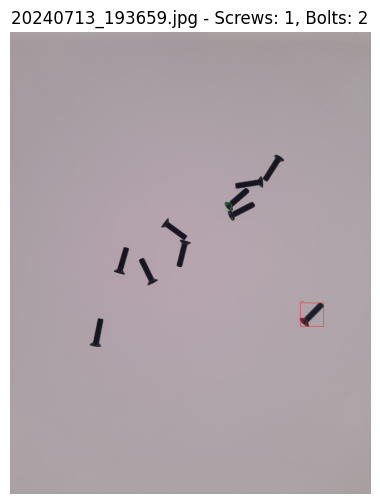

In [3]:
# Enhanced OpenCV-based Screw and Bolt Detection

import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt

def is_hexagonal_or_circular(cnt):
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    if 5 <= len(approx) <= 7:
        return True
    if len(approx) > 7:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter + 1e-5)
        return circularity > 0.6
    return False

def detect_objects(image):
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)[1]

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    screw_count = 0
    bolt_count = 0

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100 or area > 10000:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        roi = image[y:y+h, x:x+w]
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi_blur = cv2.GaussianBlur(roi_gray, (3, 3), 0)
        _, roi_thresh = cv2.threshold(roi_blur, 60, 255, cv2.THRESH_BINARY_INV)

        inner_cnts, _ = cv2.findContours(roi_thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        has_hole = False
        for ic in inner_cnts:
            if 20 < cv2.contourArea(ic) < 1000:
                if is_hexagonal_or_circular(ic):
                    has_hole = True
                    break

        if has_hole:
            label = 'Bolt'
            bolt_count += 1
            color = (0, 0, 255)
        else:
            label = 'Screw'
            screw_count += 1
            color = (0, 255, 0)

        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
        cv2.putText(output, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return output, screw_count, bolt_count

uploaded = ["20240713_192951.jpg", "20240713_194200.jpg", "20240713_194316.jpg", "20240713_193659.jpg"]

for fname in uploaded:
    image = cv2.imread(fname)
    result_img, screws, bolts = detect_objects(image)

    print(f"{fname} -> Screws: {screws}, Bolts: {bolts}")
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{fname} - Screws: {screws}, Bolts: {bolts}")
    plt.show()

